# Project 2 - Numerical Integration of Differential Equations (Damped Harmonic Oscillator)
Author: James Michael Patrick Brady <br>
ID: 10459769

## The Project In Brief
### Physical Theory
This project uses numerical integration to find numerical solutions to the differential equation of the Damped Harmonic Oscillator:

$F(t) = m\frac{d^{2}x(t)}{dt^{2}} + b\frac{dx(t)}{dt}+ kx(t)$

where $F(t)$ is the driving force (in N), $b$ is the damping constant (in kg/s), $k$ is the spring constant (in kg/s$^{2}$) and $x$ (in m) is some amplitude of the oscillation, all at some time $t$. The system also has some maximum amplitude $x_{max}$ (also in m) when undamped. These conventions will be used throughout the project code.

This equation has some general solution when $b \neq \sqrt{4km}$: 

<b>$x(t) = \exp{(\frac{-bt}{2m})}(A\exp{(Ct)}+ B\exp{(-Ct)})$</b>, where $A = (\frac{b}{2i\sqrt{4km-b^{2}}}+\frac{1}{2})x_{0} + \frac{m}{i\sqrt{4km-b^{2}}}v_{0}$, $B = x_{0}-A$ and $C = \frac{i\sqrt{4km-b^{2}}}{2m}$ 

However, when $b = \sqrt{4km}$ (the critical value of $b$) the solution is:

$x(t) = (x_{0} + (v_{0} + \frac{bx_{0}}{2m})t)\exp({\frac{-bt}{2m}})$,

given that the auxilliary equation will only have one solution, hence a solution of the form $(A + Bt)g(t)$ is required.

In the first example given, there is no external force in this system, hence $F(t) = 0$ for all $t$, that $x_{0} = x(0) = 0$ and that $v_{0} = \frac{dx}{dt} \big|_{t=0} = -1$ m/s. Hooke's Law defines that <b> $F(x) = -kx$ </b> so, the initial acceleration, $a_{0}$ must be 0 kgm/s^2.

### Summary of Project and Results

In order to investigate the physics of the mass-spring system, numerical methods had to be used to approximate the motion of the mass.

Four numerical integration methods were considered in this project:
- Euler
- Improved Euler
- Verlet
- Euler-Cromer

These methods were compared to the analytical solution at multiple time scales, of which Verlet was most accurate for each time step, likely because it is a sympletic function (one where errors average out over an oscillation). The Euler and Improved Euler methods become les accurate and degrade with an increasing time step, whereas the Euler-Cromer method remains accurate, but is sightly delayed. The Verlet method was also very accurate for the three different dampimg cases - underdamped, critically damped and overdamped and behaved as expected.

The application of a driving force to the system was then observed. When applying an instantaneous to the system, the amplitude of the oscillation increases if forced along the direction of acceleration and the amplitude decreases if driven against the direction of acceleration given the addition of forces. This effect appears to reach a maximum influence when at a stationary point with respect to velocity. When driven sinusoidally, the initial solution to the system will dominate (the transient response) until its influence has decayed and so a solution proportional to the driving force will remain. When underdamped, the amplitude of the response will be maximised and will peak at the natural frequency of the system due to the applied force and system being in phase. If critically dampeds

## Initialisation of the kernel, and defining constants
Here, all of the constants are defined, including:
- The spring constant and mass of the system and hence the critical damping constant
- The initial state of the system
- A reasonable damping constant that will provid underdamping (for demonstration purposes)
- The time step and a reasonable cutoff time, then being used to generate a list of times
- The Matplotlib graph parameters (to ensure consistent style)

In [1]:
# Importing the key modules. 
# NumPy is personally preferred over CMath in most cases, however CMath can handle complex solutions well.
import numpy as np
import matplotlib.pyplot as plt
import cmath

# Universal constants are defined using CAPITALS and SNAKE_CASE, as per general PEP-8 guidance (and out of habit)
# This means that in the constants for specific solutions to the analytical equation will be lowercase
# i.e. case switches in functions when compared to markdown definitions
# These are the constants as mentioned above:
K = 0.59 # spring constant, in kg/s^2 
M = 5.86 # mass, in kg
NAT_FREQ = np.sqrt(K/M) # Natural frequency, in rad/s
DAMPING = 0.25 # damping constant, in kg/s
DAMPING_CRIT = np.sqrt(4*K*M) # Critical value of damping constant, in kg/s
X_0 = 0 # Initial displacement, in m
VEL_0 = -1 # Intial velocity, in m/s
ACC_0 = 0 # Initial acceleration via Hooke's Law, in kgm/s^2
X_MAX = 1 # maximum amplitude, in m 
H = 0.02 # time step, in s
TIME_MAX = 120 # cutoff, in s

plt.rcParams['figure.figsize'] = [12,8] # Sets universal figure size (it's easier to read than default)
plt.rcParams['font.size'] = '16' # Sets universal font size, which is easier to read than the default 12px font

# Generates an array of times within the maximum time, sepearated by the step, h, each time.
# This array is used throughout the whole project
times = np.arange(0, TIME_MAX + H, H)

## Finding the Analytical Solution to the Oscillator

The analytical solution is defined as a function, using the definition of the system's solution as outlined above. This makes general applications and comparisons using different parameter values far more convenient. The solution to the initial parameters is then plotted below. For reference, the time step used at this stage is 20 ms.

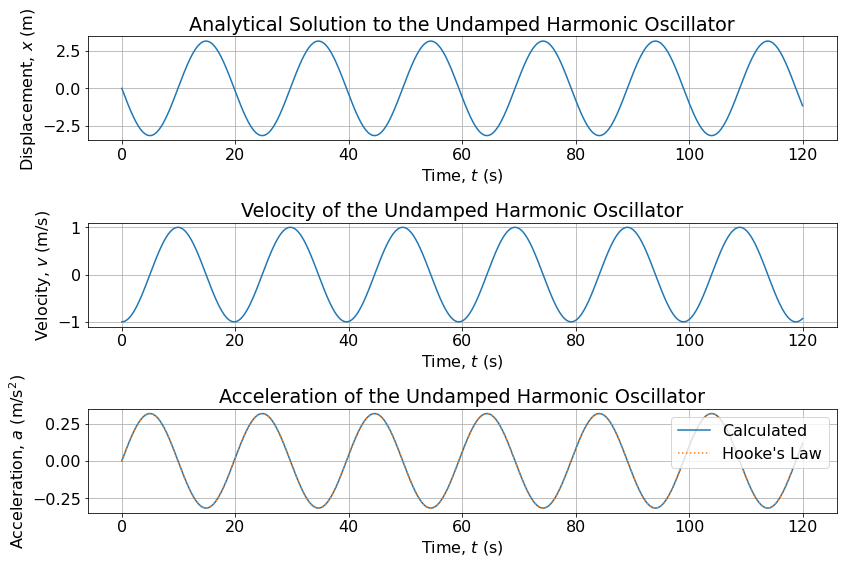

In [2]:
# This is the analytical solution of the Damped Harmonic Oscillator, for all cases
def analytical_solution(time, x0, v0, B=DAMPING):
    if B != DAMPING_CRIT :
        # This is the solution when the damping constant is not the critical value
        # This calculates x EXACTLY for any given time, t.
        # This only works because our initial conditions allow for a real solution to be taken.
        # As x(0) = 0 and v(0) = -1 this implies a solution using -sin(t * (K/M)**(1/2)
        a = (B/(2*1j*cmath.sqrt(4*K*M - B**2))+1/2)*x0+v0*M/(cmath.sqrt(4*K*M - B**2)*1j)
        b = x0-a
        c = (1j * cmath.sqrt(4*K*M - B**2))/(2*M)
        x = np.exp(-B*time/(2*M)) * (a * np.exp(c*time) + b*np.exp(-c*time))
    else:
        # This is the solution for the edge-case where the damping constant is at its critical value
        a = x0
        b = (v0 + (B * x0)/(2 * M))
        x = (a + b * time) * np.exp(-B * time / (2 * M))
    return x

def analytical_vel_and_acc(time, x, x0, v0, B=DAMPING):
    # Velocity was found by taking the first differential of x(t), Hooke's Law was used to find the acceleration 
    # Requires x values from analytical_solution() to be used in place of x.  
    if B != DAMPING_CRIT :
        a = (B/(2*1j*cmath.sqrt(4*K*M - B**2))+1/2)*x0+v0*M/(cmath.sqrt(4*K*M - B**2)*1j)
        b = x0-a
        c = (1j * cmath.sqrt(4*K*M - B**2))/(2*M)
        vel = -(B/2*M)*x + c*(a*np.exp(c*time) - b*np.exp(-c*time))*np.exp(-B*time/(2*M))
        acc = ((B**2 + 2*M*c**2)/(2*M))*x - ((B*c)/(2*M))*(a*np.exp(c*time) - b*np.exp(-c*time))*np.exp(-B*time/(2*M))
    else:
        a = x0
        b = (v0 + (B * x0)/(2 * M))
        vel = (-B/(2*M))*x + b*np.exp((-B*time)/(2*M))
        acc = ((-B/(2*M))**2)*x - ((b*B)/M)*np.exp((-B*time)/(2*M))
    return vel.real, acc.real
        
# Simulating the undamped solution to the system's motion
x_analytic_complex = analytical_solution(times, X_0, VEL_0,0)
vel_analytic, acc_analytic = analytical_vel_and_acc(times, x_analytic_complex, X_0, VEL_0,0)
x_analytic = x_analytic_complex.real

# Plots the undamped analytical solution to the differential equation, along with the first and second derivatives
figure = plt.figure()
axes = figure.add_subplot(311)
axes.plot(times, x_analytic)
axes.set_xlabel("Time, $t$ (s)")
axes.set_ylabel("Displacement, $x$ (m)")
axes.grid()
axes.set_title("Analytical Solution to the Undamped Harmonic Oscillator")

axes_2 = figure.add_subplot(312)
axes_2.plot(times, vel_analytic)
axes_2.set_xlabel("Time, $t$ (s)")
axes_2.set_ylabel("Velocity, $v$ (m/s)")
axes_2.grid()
axes_2.set_title("Velocity of the Undamped Harmonic Oscillator")

axes_3 = figure.add_subplot(313)
axes_3.plot(times, acc_analytic, label="Calculated")
axes_3.plot(times, -(K/M)*x_analytic, linestyle="dotted", label="Hooke's Law")
axes_3.set_xlabel("Time, $t$ (s)")
axes_3.set_ylabel(r"Acceleration, $a$ (m/s$^{2}$)")
axes_3.grid()
axes_3.set_title("Acceleration of the Undamped Harmonic Oscillator")
axes_3.legend(loc="upper right")
plt.tight_layout()
plt.show()

As can be seen above, the analytical solution is periodic in nature, as suggested by the solution depending on $\exp{(i\omega t)}$, a complex expression of a sinusoidal function. The acceleration found via the analytical method is almost exactly a match with those determined by Hooke's Law (it is proportional to and in exact antiphase with the displacement) and hence the method is likely physically accurate. In addition, the velocity is also periodic (as expected from the derivative of an exponential of form $\exp{(i\omega t)}$ and in the undamped case has a phase difference  of $\frac{\pi}{2}$ to $x(t)$ given a factor of $i = \exp{i\frac{\pi}{2}}$ produced by the derivative.

When a damping constant is applied to the system, there is a decay in the maximum displacement, velocity and acceleration over time. The displacement and acceleration remain in exact antiphase, however the phase difference between the displacement and velocity changes, as can be seen below:

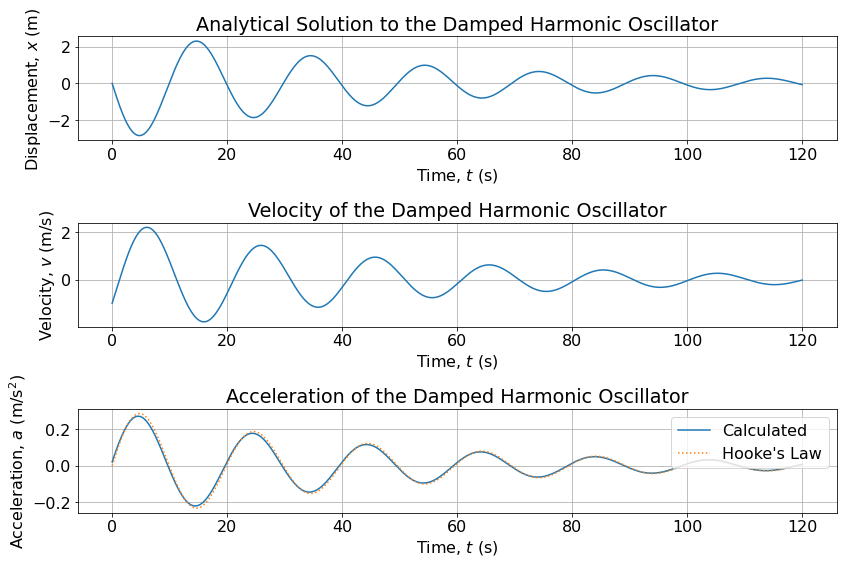

In [3]:
# Calculating the damped solution of the system
x_analytic_complex = analytical_solution(times, X_0, VEL_0)
vel_analytic, acc_analytic = analytical_vel_and_acc(times, x_analytic_complex, X_0, VEL_0)
x_analytic = x_analytic_complex.real

# Plots the analytical solution to the damped equation
figure = plt.figure()
axes = figure.add_subplot(311)
axes.plot(times, x_analytic)
axes.set_xlabel("Time, $t$ (s)")
axes.set_ylabel("Displacement, $x$ (m)")
axes.grid()
axes.set_title("Analytical Solution to the Damped Harmonic Oscillator")

axes_2 = figure.add_subplot(312)
axes_2.plot(times, vel_analytic)
axes_2.set_xlabel("Time, $t$ (s)")
axes_2.set_ylabel("Velocity, $v$ (m/s)")
axes_2.grid()
axes_2.set_title("Velocity of the Damped Harmonic Oscillator")

axes_3 = figure.add_subplot(313)
axes_3.plot(times, acc_analytic, label="Calculated")
axes_3.plot(times, -(K/M)*x_analytic, linestyle="dotted", label="Hooke's Law")
axes_3.set_xlabel("Time, $t$ (s)")
axes_3.set_ylabel(r"Acceleration, $a$ (m/s$^{2}$)")
axes_3.grid()
axes_3.set_title("Acceleration of the Damped Harmonic Oscillator")
axes_3.legend(loc="upper right")
plt.tight_layout()
plt.show()

This phase change likely occurs because there is an additional reliance on the damping constant in the equation, hence whilst the solution to acceleration will be the same given that $\frac{d^{2}x(t)}{dt^{2}} \propto x(t)$ in the damped case, the velocity will have an additional reliance on $b$ that the undamped case did not have, hence it is reasonable to expect that the velocity's phase difference would have changed:

$ v(t) = Re(\frac{dx}{dt}) = \frac{-b}{2m}x(t) + C(A\exp{(Ct)} - B\exp{(-Ct)})\exp{\frac{-bt}{2m}}$, 

or $v(t) = \frac{-b}{2m}x(t) + B\exp{\frac{-bt}{2m}}$ when critically damped.

## Implementing the Numerical Methods

### Part 1 - Determining the Best Method

Out of the various numerical methods provided, the best one must be found in order to model the system well.

The <b> Euler Method </b> is defined as such for a time step $h$:

$x_{i+1} = x_{i} + hv_{i}$ where $v_{i+1} = v_{i} + ha_{i}$ and $a_{i} = -\frac{K}{M}x_{i} -\frac{B}{M}v_{i}$


The <b> Improved Euler Method </b> acts as a modification accounting for acceleration directly in the solution for $x$:

$x_{i+1} = x_{i} + hv_{i} + \frac{1}{2}h^{2}a_{i}$, 

$v_{i+1}$ and $a_{i+1}$ defined as before.


The <b> Verlet Method </b> defines a solution for $x_{i+1}$:

$x_{i+1} = Ax_{i} + Bx_{i-1}$, where $A = \frac{2(2mk-h^{2})}{2m + bh}$ and $B = \frac{bh - 2m}{2m + bh}$

This method requires a second term, $x_{1}$ to be defined through another method first before it becomes usable.


The <b> Euler-Cromer Method </b> is defined in the same way as the Euler Method, except that $v_{i}$ is replaced with $v_{i+1}$:

$x_{i+1} = x_{i} + hv_{i+1}$, where $v_{i+1} = v_{i} + ha_{i}$ and $a_{i} = -\frac{K}{M}x_{i} -\frac{B}{M}v_{i}$ as before


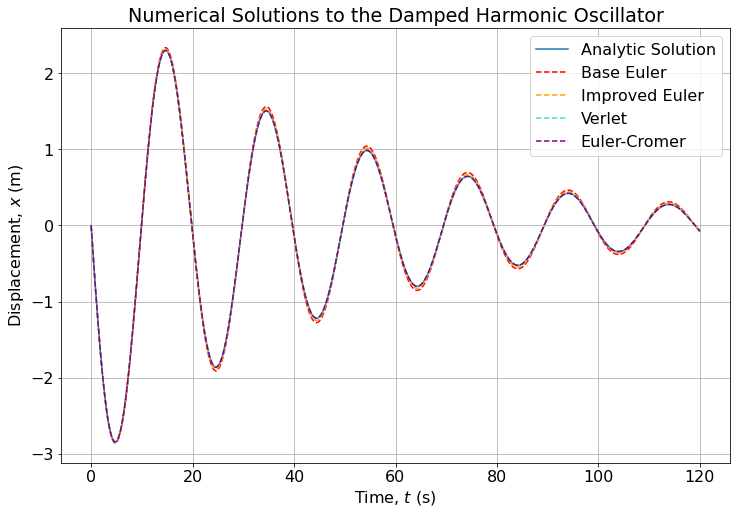

In [4]:
def euler(x_0, vel_0, time_step, time, B=DAMPING):
    # Implementation of the Euler Method
    x_arr = np.zeros(len(time))
    vel_arr = np.zeros(len(time))
    x_arr[0] = x_0
    vel_arr[0] = vel_0
    
    # Considers the dynamics of the spring as a series of linear gradients with a fixed time step, H.
    # Obeys standard Newtonian dynamics, i.e. x_i+1 = x_1 + vt and v = u + at. 
    for i in range(len(time)-1):
        acc = -(K/M) * x_arr[i] -(B/M) * vel_arr[i]
        x_arr[i+1] = x_arr[i] + vel_arr[i] * time_step
        vel_arr[i+1] = vel_arr[i] + acc * time_step
    
    return x_arr.real, vel_arr.real

x_euler, vel_euler = euler(X_0, VEL_0, H, times)

def euler_improved(x_0, vel_0, time_step, time, B=DAMPING):
    # Implementation of the Improved Euler method
    x_arr = np.zeros(len(time))
    vel_arr = np.zeros(len(time))
    x_arr[0] = x_0
    vel_arr[0] = vel_0
   
    # As with the Euler Method above, just with a Taylor expanded acceleration factor considered
    # i.e. x_i+1 = x_i + vh + 1/2 ah
    for i in range(len(time)-1):
        acc = -(K/M) * x_arr[i] - (B/M) * vel_arr[i]
        x_arr[i+1] = x_arr[i] + vel_arr[i] * time_step + (1/2) * (time_step**2) * acc
        vel_arr[i+1] = vel_arr[i] + acc * time_step
    
    return x_arr.real, vel_arr.real

x_euler_imp, vel_euler_imp = euler_improved(X_0, VEL_0, H, times)

# Using Improved Euler to generate the second x,v terms for Verlet 
X_1 = x_euler_imp[1]

def verlet(x_0, x_1, time_step, time, B=DAMPING):
    d = 2 * M + B * time_step
    a = 2 * (2 * M - K * time_step**2) / d
    b = (B * time_step - 2 * M) / d
    
    x_arr = np.zeros(len(time))
    x_arr[0] = x_0
    x_arr[1] = x_1
    x_arr[2] = a * x_1 - b * x_0
    
    for i in range(len(time)-1):
        if i <= 1:
            continue
        else:
            x_arr[i+1] = a * x_arr[i] + b * x_arr[i-1]
    return x_arr.real

x_verlet = verlet(X_0, X_1, H, times)

def euler_cromer(x_0, vel_0, time_step, time, B=DAMPING):
    # Implementation of the Euler-Cromer Method
    x_arr = np.zeros(len(time))
    vel_arr = np.zeros(len(time))
    x_arr[0] = x_0
    vel_arr[0] = vel_0
    
    # Considers the dynamics of the spring as a series of linear gradients with a fixed time step, H.
    for i in range(len(time)-1):
        acc = -(K/M) * x_arr[i] -(B/M) * vel_arr[i]
        vel_next = vel_arr[i] + time_step * acc
        if i < len(time):
            vel_arr[i+1] = vel_next
        x_arr[i+1] = x_arr[i] + vel_next * time_step

    return x_arr.real, vel_arr.real

x_cromer, vel_cromer = euler_cromer(X_0, VEL_0, H, times) 

figure = plt.figure()
axes = figure.add_subplot(111)
axes.plot(times, x_analytic, label = "Analytic Solution")
axes.plot(times, x_euler, linestyle="dashed", color = "red", label = "Base Euler")
axes.plot(times, x_euler_imp, linestyle="dashed", color = "orange", label = "Improved Euler")
axes.plot(times, x_verlet, linestyle="dashed", color = "turquoise", label = "Verlet")
axes.plot(times, x_cromer, linestyle="dashed", color = "purple", label = "Euler-Cromer")
axes.set_xlabel("Time, $t$ (s)")
axes.set_ylabel("Displacement, $x$ (m)")
axes.grid()
axes.legend()
axes.set_title("Numerical Solutions to the Damped Harmonic Oscillator")
plt.show()

Let's zoom in  and take the residuals at the last peak in this graph (due to it having an appropriate time evolution):

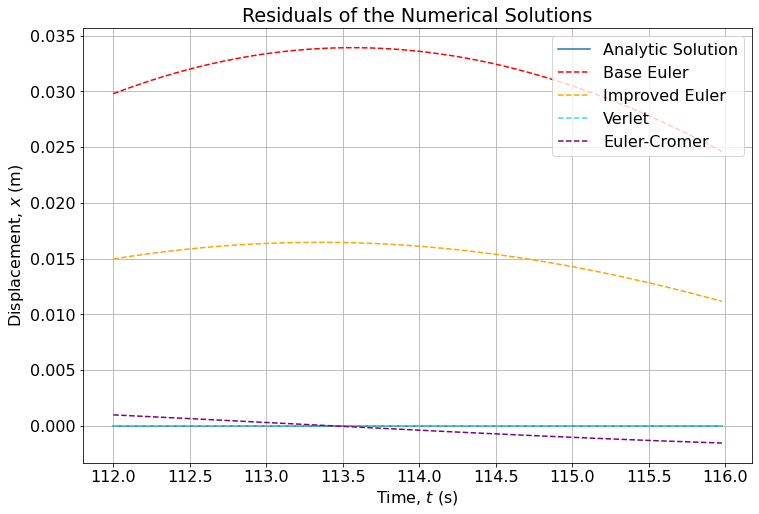

In [5]:
# Cropping the times to zoom in
time_i_low = np.where(times == 112)[0][0]
time_i_up = np.where(times == 116)[0][0]

times_zoom = times[time_i_low:time_i_up]
x_analytic_zoom = x_analytic[time_i_low:time_i_up]
x_euler_zoom = x_euler[time_i_low:time_i_up]
x_euler_imp_zoom = x_euler_imp[time_i_low:time_i_up]
x_verlet_zoom = x_verlet[time_i_low:time_i_up]
x_cromer_zoom = x_cromer[time_i_low:time_i_up]

# Plotting the crops of the data
figure = plt.figure()
axes = figure.add_subplot(111)
axes.plot(times_zoom, x_analytic_zoom - x_analytic_zoom, label = "Analytic Solution")
axes.plot(times_zoom, x_euler_zoom - x_analytic_zoom, linestyle="dashed", color = "red", label = "Base Euler")
axes.plot(times_zoom, x_euler_imp_zoom - x_analytic_zoom, linestyle="dashed", color = "orange", label = "Improved Euler")
axes.plot(times_zoom, x_verlet_zoom - x_analytic_zoom, linestyle="dashed", color = "turquoise", label = "Verlet")
axes.plot(times_zoom, x_cromer_zoom - x_analytic_zoom, linestyle="dashed", color = "purple", label = "Euler-Cromer")
axes.set_xlabel("Time, $t$ (s)")
axes.set_ylabel("Displacement, $x$ (m)")
axes.grid()
axes.legend()
axes.set_title("Residuals of the Numerical Solutions")
plt.show()

From the above graphs, it is clear that for a suitably small time step (i.e ~ 20 ms comapred to a period ~ 10 s), both the Verlet and Euler-Cromer methods are far more accurate and precise compared to the Euler and Improved Euler methods, with respect to the analytic solution. Out of the two more accurate methods, the Euler-Cromer method appears to slightly deviate from or lag behind analytic solution, whereas the Verlet method almost exactly overlaps the analytic solution.


### Part 2 - Investigating the Effect of Different Time Steps
Let's see what happens at multiple larger time steps:
- 100 milliseconds
- 200 miliseconds
- 1000 milliseconds

and a smaller timestep, 5 milliseconds.

Given the definitions of the numerical solutions, we can expect the quality and accuracy of the Euler and Improved Euler methods to degrade as the time step increases, but improve as the time step decreases. It may be possible that the Euler-Cromer method also degrades, however it is known to be a sympletic method (errors average out over oscillations, in this case due to dependencies on derivatives at later points) and so is likely to remain more accurate than the other Euler methods. It is hard to judge how the Verlet method will act, due to having a more complicated dependency on $h$, though it is likely to be sympletic like the Euler-Cromer method.  

Below is the simulation at each timestep in order:

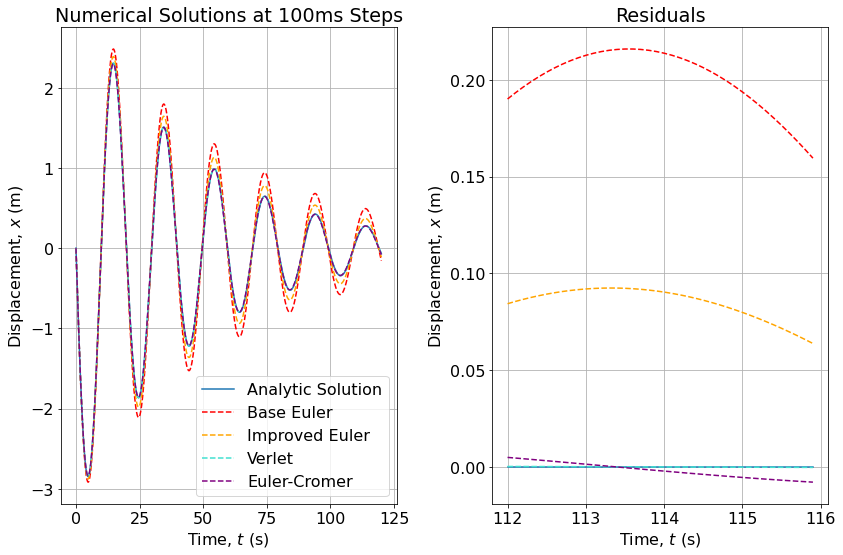

In [6]:
# Method is same as above
H_100ms = 0.1 # in s
times_100ms = np.arange(0, TIME_MAX + H_100ms, H_100ms)
x_euler, vel_euler = euler(X_0, VEL_0, H_100ms, times_100ms)
x_analytic = analytical_solution(times_100ms, X_0, VEL_0).real
x_euler_imp, vel_euler_imp = euler_improved(X_0, VEL_0, H_100ms, times_100ms)
X_1 = x_euler_imp[1]
x_verlet = verlet(X_0, X_1, H_100ms, times_100ms)
x_cromer, vel_cromer = euler_cromer(X_0, VEL_0, H_100ms, times_100ms)

figure = plt.figure()
axes = figure.add_subplot(121)
axes.plot(times_100ms, x_analytic, label = "Analytic Solution")
axes.plot(times_100ms, x_euler, linestyle="dashed", color = "red", label = "Base Euler")
axes.plot(times_100ms, x_euler_imp, linestyle="dashed", color = "orange", label = "Improved Euler")
axes.plot(times_100ms, x_verlet, linestyle="dashed", color = "turquoise", label = "Verlet")
axes.plot(times_100ms, x_cromer, linestyle="dashed", color = "purple", label = "Euler-Cromer")
axes.set_xlabel("Time, $t$ (s)")
axes.set_ylabel("Displacement, $x$ (m)")
axes.grid()
axes.legend()
axes.set_title("Numerical Solutions at 100ms Steps")

time_i_low = np.where(times_100ms == 112)[0][0]
time_i_up = np.where(times_100ms == 116)[0][0]

times_zoom = times_100ms[time_i_low:time_i_up]
x_analytic_zoom = x_analytic[time_i_low:time_i_up]
x_euler_zoom = x_euler[time_i_low:time_i_up]
x_euler_imp_zoom = x_euler_imp[time_i_low:time_i_up]
x_verlet_zoom = x_verlet[time_i_low:time_i_up]
x_cromer_zoom = x_cromer[time_i_low:time_i_up]

axes_2 = figure.add_subplot(122)
axes_2.plot(times_zoom, x_analytic_zoom - x_analytic_zoom)
axes_2.plot(times_zoom, x_euler_zoom - x_analytic_zoom, linestyle="dashed", color = "red")
axes_2.plot(times_zoom, x_euler_imp_zoom - x_analytic_zoom, linestyle="dashed", color = "orange")
axes_2.plot(times_zoom, x_verlet_zoom - x_analytic_zoom, linestyle="dashed", color = "turquoise")
axes_2.plot(times_zoom, x_cromer_zoom - x_analytic_zoom, linestyle="dashed", color = "purple")
axes_2.set_xlabel("Time, $t$ (s)")
axes_2.set_ylabel("Displacement, $x$ (m)")
axes_2.grid()
axes_2.set_title("Residuals")
plt.tight_layout()
plt.show()

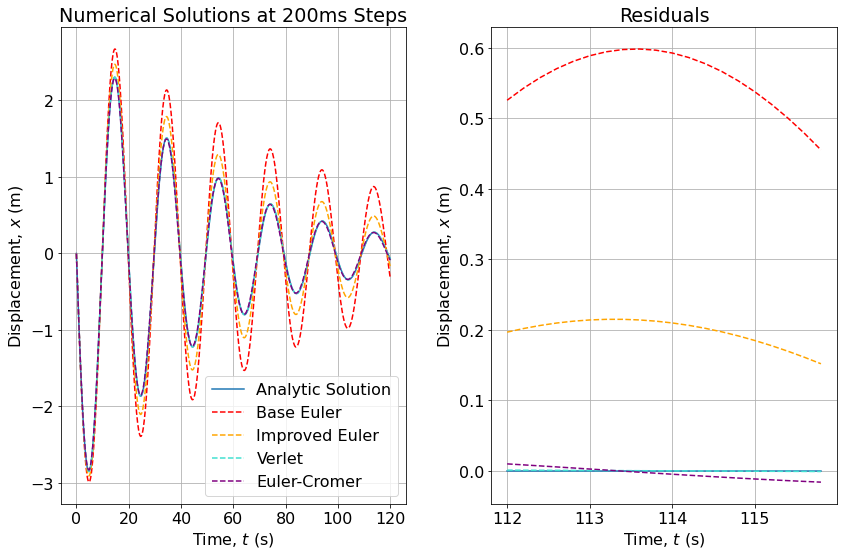

In [7]:
H_200ms = 0.2 # in s
times_200ms = np.arange(0, TIME_MAX + H_200ms, H_200ms)
x_euler, vel_euler = euler(X_0, VEL_0, H_200ms, times_200ms)
x_analytic = analytical_solution(times_200ms, X_0, VEL_0).real
x_euler_imp, vel_euler_imp = euler_improved(X_0, VEL_0, H_200ms, times_200ms)
X_1 = x_euler_imp[1]
x_verlet = verlet(X_0, X_1, H_200ms, times_200ms)
x_cromer, vel_cromer = euler_cromer(X_0, VEL_0, H_200ms, times_200ms)

figure = plt.figure()
axes = figure.add_subplot(121)
axes.plot(times_200ms, x_analytic, label = "Analytic Solution")
axes.plot(times_200ms, x_euler, linestyle="dashed", color = "red", label = "Base Euler")
axes.plot(times_200ms, x_euler_imp, linestyle="dashed", color = "orange", label = "Improved Euler")
axes.plot(times_200ms, x_verlet, linestyle="dashed", color = "turquoise", label = "Verlet")
axes.plot(times_200ms, x_cromer, linestyle="dashed", color = "purple", label = "Euler-Cromer")
axes.set_xlabel("Time, $t$ (s)")
axes.set_ylabel("Displacement, $x$ (m)")
axes.grid()
axes.legend()
axes.set_title("Numerical Solutions at 200ms Steps")

time_i_low = np.where(times_200ms == 112)[0][0]
time_i_up = np.where(times_200ms == 116)[0][0]

times_zoom = times_200ms[time_i_low:time_i_up]
x_analytic_zoom = x_analytic[time_i_low:time_i_up]
x_euler_zoom = x_euler[time_i_low:time_i_up]
x_euler_imp_zoom = x_euler_imp[time_i_low:time_i_up]
x_verlet_zoom = x_verlet[time_i_low:time_i_up]
x_cromer_zoom = x_cromer[time_i_low:time_i_up]

axes_2 = figure.add_subplot(122)
axes_2.plot(times_zoom, x_analytic_zoom - x_analytic_zoom)
axes_2.plot(times_zoom, x_euler_zoom - x_analytic_zoom, linestyle="dashed", color = "red")
axes_2.plot(times_zoom, x_euler_imp_zoom - x_analytic_zoom, linestyle="dashed", color = "orange")
axes_2.plot(times_zoom, x_verlet_zoom - x_analytic_zoom, linestyle="dashed", color = "turquoise")
axes_2.plot(times_zoom, x_cromer_zoom - x_analytic_zoom, linestyle="dashed", color = "purple")
axes_2.set_xlabel("Time, $t$ (s)")
axes_2.set_ylabel("Displacement, $x$ (m)")
axes_2.grid()
axes_2.set_title("Residuals")
plt.tight_layout()
plt.show()

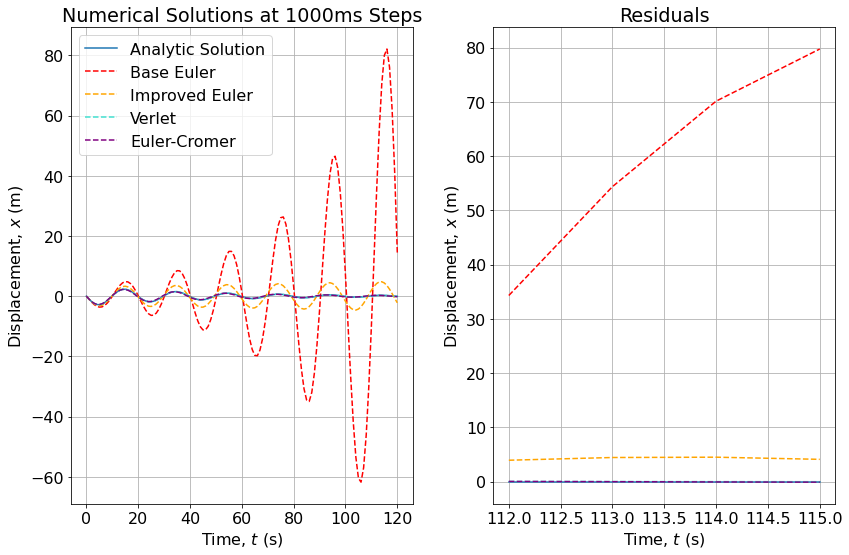

In [8]:
H_1000ms = 1 # in s
times_1000ms = np.arange(0, TIME_MAX + H_1000ms, H_1000ms)
x_euler, vel_euler = euler(X_0, VEL_0, H_1000ms, times_1000ms)
x_analytic = analytical_solution(times_1000ms, X_0, VEL_0).real
x_euler_imp, vel_euler_imp = euler_improved(X_0, VEL_0, H_1000ms, times_1000ms)
X_1 = x_euler_imp[1]
x_verlet = verlet(X_0, X_1, H_1000ms, times_1000ms)
x_cromer, vel_cromer = euler_cromer(X_0, VEL_0, H_1000ms, times_1000ms)

figure = plt.figure()
axes = figure.add_subplot(121)
axes.plot(times_1000ms, x_analytic, label = "Analytic Solution")
axes.plot(times_1000ms, x_euler, linestyle="dashed", color = "red", label = "Base Euler")
axes.plot(times_1000ms, x_euler_imp, linestyle="dashed", color = "orange", label = "Improved Euler")
axes.plot(times_1000ms, x_verlet, linestyle="dashed", color = "turquoise", label = "Verlet")
axes.plot(times_1000ms, x_cromer, linestyle="dashed", color = "purple", label = "Euler-Cromer")
axes.set_xlabel("Time, $t$ (s)")
axes.set_ylabel("Displacement, $x$ (m)")
axes.grid()
axes.legend()
axes.set_title("Numerical Solutions at 1000ms Steps")

time_i_low = np.where(times_1000ms == 112)[0][0]
time_i_up = np.where(times_1000ms == 116)[0][0]

times_zoom = times_1000ms[time_i_low:time_i_up]
x_analytic_zoom = x_analytic[time_i_low:time_i_up]
x_euler_zoom = x_euler[time_i_low:time_i_up]
x_euler_imp_zoom = x_euler_imp[time_i_low:time_i_up]
x_verlet_zoom = x_verlet[time_i_low:time_i_up]
x_cromer_zoom = x_cromer[time_i_low:time_i_up]

axes_2 = figure.add_subplot(122)
axes_2.plot(times_zoom, x_analytic_zoom - x_analytic_zoom)
axes_2.plot(times_zoom, x_euler_zoom - x_analytic_zoom, linestyle="dashed", color = "red")
axes_2.plot(times_zoom, x_euler_imp_zoom - x_analytic_zoom, linestyle="dashed", color = "orange")
axes_2.plot(times_zoom, x_verlet_zoom - x_analytic_zoom, linestyle="dashed", color = "turquoise")
axes_2.plot(times_zoom, x_cromer_zoom - x_analytic_zoom, linestyle="dashed", color = "purple")
axes_2.set_xlabel("Time, $t$ (s)")
axes_2.set_ylabel("Displacement, $x$ (m)")
axes_2.grid()
axes_2.set_title(r"Residuals")
plt.tight_layout()
plt.show()

It is clear that as the time step incrases, the accuracy of most of the methods decrease. Of the four methods, it is clear that the Euler method is the most prone to error at large time steps and time evolution. This should be somewhat expected, as using the Euler relation with zero damping, and the relation:

$E_{i} = \frac{1}{2}Kx_{i}^{2} + \frac{1}{2}Mv_{i}^{2}$,

we can find that:

$E_{i+1} = (1 + \frac{K}{M}h^{2})E_{i}$,

hence the Euler relation has some energy error $O(h^{2})$ in the undamped case and will have only minor corrections through damping. This directly contributes to some error in the displacement given the energy of the system and hence represents an energy that will either increase with time (in the undamped case and physically impossible, unless driven) or decrease less than expected (in the damped case).

Likewise, the error on the Improved Euler method has some order $O(h^{4})$ when finding $E_{i+1}$ in terms of $E_{i}$. However, this error also has an intrinsic correction of order $O(h^{2})$ against the gain, leading to a smaller overall error on this method than the Euler method.

The energies of the Euler-Cromer and Verlet methods also contain multiple error sources of several orders (generally combining $O(n^{2})$, $O(n^{3})$ and $O(n^{4})$ in a polynomial), however they have either direct dependencies on either the current term 
or previous and next terms, meaning that they will tend to average out over multiple oscillations and hence can be regarded as sympletic. It could also be stated that the Improved Euler method is also somewhat sympletic (especially for smaller time steps), however the graphs above still show a clear bias towards predicting higher energies than expected (even if it is significantly better than Euler) by producing larger displacements at stationary points and so it is not as sympletic as Verlet or Euler-Cromer.  

It is also clear that both the Euler-Cromer and Verlet methods are both suitably accurate at reasonable timescales. However, the Euler-Cromer method is consistently offset from the expected displacements, whereas the Verlet method is not, thus making the Verlet method the more accurate model for many timescales. However, any offsets from the expectation using the Euler-Cromer method should average out over one cycle of propagation, so it is also a reasonably accurate model. 

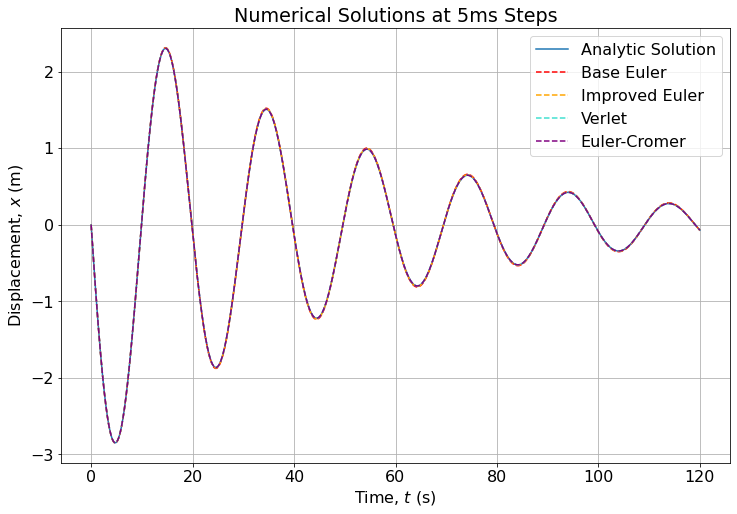

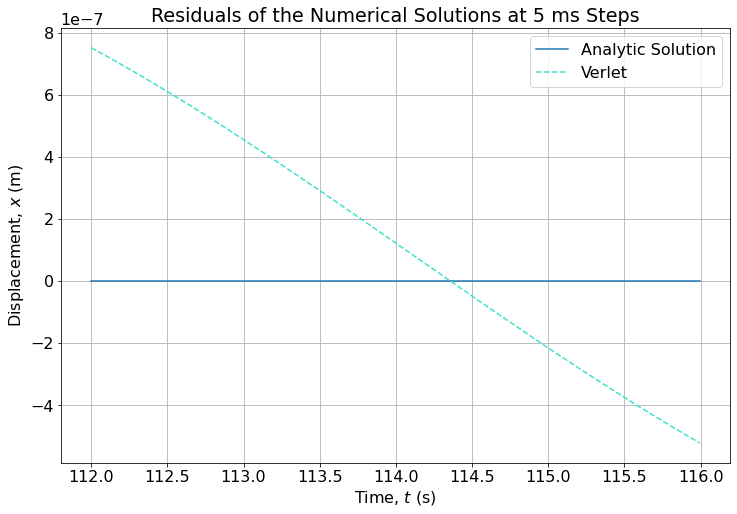

In [9]:
#Fix the naming conventions
H_5ms = 0.005 # in s
times_5ms = np.arange(0, TIME_MAX + H_5ms, H_5ms)
x_euler, vel_euler = euler(X_0, VEL_0, H_5ms, times_5ms)
x_analytic = analytical_solution(times_5ms, X_0, VEL_0).real
x_euler_imp, vel_euler_imp = euler_improved(X_0, VEL_0, H_5ms, times_5ms)
X_1 = x_euler_imp[1]
x_verlet = verlet(X_0, X_1, H_5ms, times_5ms)
x_cromer, vel_cromer = euler_cromer(X_0, VEL_0, H_5ms, times_5ms)

figure = plt.figure()
axes = figure.add_subplot(111)
axes.plot(times_5ms, x_analytic, label = "Analytic Solution")
axes.plot(times_5ms, x_euler, linestyle="dashed", color = "red", label = "Base Euler")
axes.plot(times_5ms, x_euler_imp, linestyle="dashed", color = "orange", label = "Improved Euler")
axes.plot(times_5ms, x_verlet, linestyle="dashed", color = "turquoise", label = "Verlet")
axes.plot(times_5ms, x_cromer, linestyle="dashed", color = "purple", label = "Euler-Cromer")
axes.set_xlabel("Time, $t$ (s)")
axes.set_ylabel("Displacement, $x$ (m)")
axes.grid()
axes.legend()
axes.set_title("Numerical Solutions at 5ms Steps")
plt.show()

time_i_low = np.where(times_5ms == 112)[0][0]
time_i_up = np.where(times_5ms == 116)[0][0]

times_zoom = times_5ms[time_i_low:time_i_up]
x_analytic_zoom = x_analytic[time_i_low:time_i_up]
x_euler_zoom = x_euler[time_i_low:time_i_up]
x_euler_imp_zoom = x_euler_imp[time_i_low:time_i_up]
x_verlet_zoom = x_verlet[time_i_low:time_i_up]
x_cromer_zoom = x_cromer[time_i_low:time_i_up]

# Showing the large degree of accuracy of the Verlet Method
figure = plt.figure()
axes = figure.add_subplot(111)
axes.plot(times_zoom, x_analytic_zoom - x_analytic_zoom, label = "Analytic Solution")
#axes.plot(times_zoom, x_euler_zoom - x_analytic_zoom, linestyle="dashed", color = "red", label = "Base Euler")
#axes.plot(times_zoom, x_euler_imp_zoom - x_analytic_zoom, linestyle="dashed", color = "orange", label = "Improved Euler")
axes.plot(times_zoom, x_verlet_zoom - x_analytic_zoom, linestyle="dashed", color = "turquoise", label = "Verlet")
#axes.plot(times_zoom, x_cromer_zoom - x_analytic_zoom, linestyle="dashed", color = "purple", label = "Euler-Cromer")
axes.set_xlabel("Time, $t$ (s)")
axes.set_ylabel("Displacement, $x$ (m)")
axes.grid()
axes.legend()
axes.set_title("Residuals of the Numerical Solutions at 5 ms Steps")
plt.show()

As expected, the Euler and Improved Euler methods are very accurate for a small timestep, as suggested by their reliances on $h$. However, both the the Verlet and Euler-Cromer methods maintain accuracy (as expected from being sympletic functions), with Verlet having an error on displacement of the order $10^{-7}$. 

Hence, it is clear that for a wide range of cases, Verlet is by far the best method to use, due to its incredibly high accuracy, even when compared to another "good" method such as the Euler-Cromer method.

However, what happens when multiple damping values are used for the Verlet method?

### Part 3 - Investigating the Effect of Damping on the Verlet Method's Accuracy
Let's investigate the effects at:
- Half of the critical value
- The critical value
- Double the critical value

These respectively correspond to the underdamped case, the critically damped case and the overdamped case.

Recalling the analytical solution to the displacement as outlined above,

$x(t) = \exp{(\frac{-bt}{2m})}(A\exp{(Ct)}+ B\exp{(-Ct)})$ and that $C = \frac{i\sqrt{4km-b^{2}}}{2m}$

we can define the critcal damping constant, $b_{crit} = \sqrt{4km}$ such that $ C \rightarrow 0$ and thus the critically damped case is required:

$x(t) = (x_{0} + (v_{0} + \frac{bx_{0}}{2m})t)\exp({\frac{-bt}{2m}})$.

Theoretically, the critically damped case should decay the fastest out of all cases given that the oscillation terms become negligible and so there will be a peak displacement follwed by a quick decay to 0. The constants used are also of a simpler form than $A$ and $B$ and so the amplitude should also be lower. 

The next fastest to decay should be the overdamped case, as when $b \rightarrow \infty$, $\exp{\frac{-bt}{2m}} \rightarrow 0$, however it is reliant on the general case and so will have a longer oscillation period as $b$ increases, meaning that the system will take longer to decay. It is notable that the system will not oscillate, given that it is past the point of critical damping, however because the damping will be out of phase with the tendency of the system this must decay slowly. the amplitude is likely to be larger than the critical case at any point because it relies on the more complicated (and larger) values of $A$ and $B$ produced in the general case.

The slowest to decay should be the underdamped case - this is expected as it is what we have seen so far. There will still be oscillations which will take far longer to decay than the critical case, up to the limit of the undamped case, where the oscillations will not decay at all. This case should have the largest amplitude.

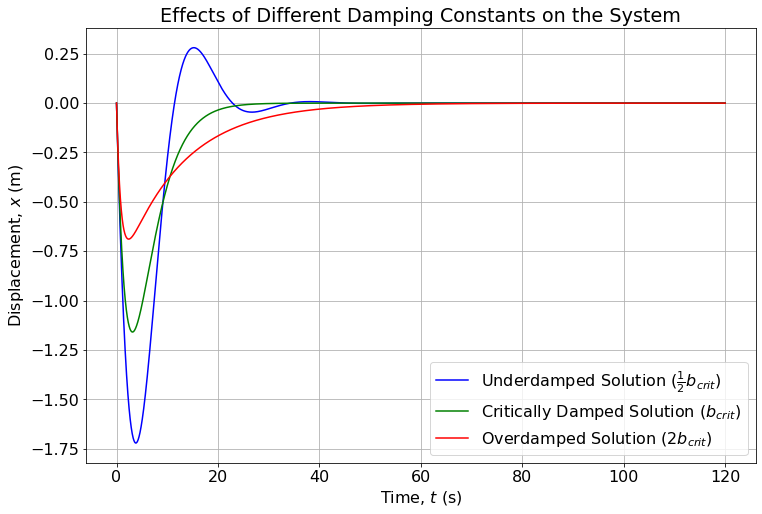

In [10]:
# Calculating the analytical solutions to the damped motion
analytic_half_crit = analytical_solution(times, X_0, VEL_0, DAMPING_CRIT/2).real
analytic_crit = analytical_solution(times, X_0, VEL_0, DAMPING_CRIT).real
analytic_double_crit = analytical_solution(times, X_0, VEL_0, 2*DAMPING_CRIT).real

figure = plt.figure()
axes = figure.add_subplot(111)
axes.plot(times, analytic_half_crit, label = r"Underdamped Solution ($\frac{1}{2}b_{crit}$)", color="blue")
axes.plot(times, analytic_crit, label = r"Critically Damped Solution ($b_{crit}$)", color="green")
axes.plot(times, analytic_double_crit, label = r"Overdamped Solution ($2b_{crit}$)", color="red")
axes.set_xlabel("Time, $t$ (s)")
axes.set_ylabel("Displacement, $x$ (m)")
axes.grid()
axes.legend()
axes.set_title("Effects of Different Damping Constants on the System")
plt.show()

As can be seen above, all of these instances approach a value of zero displacement faster than a with smaller damping cosntant (as with the value, 0.5 kg/s, used before). As the damping constant increases, it is clear that the maximum amplitude the system reachs decreases drastically, due to a higher resistive force against oscillation. The underdamped solution still oscillates slightly, as the damping is not large enough to prevent it, whereas the critical and overdamped cases do not oscillate. Critical damping reaches zero oscillations in a stable manner faster than the underdamped and overdamped cases, as both have residual exponential terms. All three of the plots appear to reach a stable zero level at around the 60 s mark.

Let's plot the Verlet approximation to the analytical solutions for times $0 \leq t \leq 60$ (in s): 

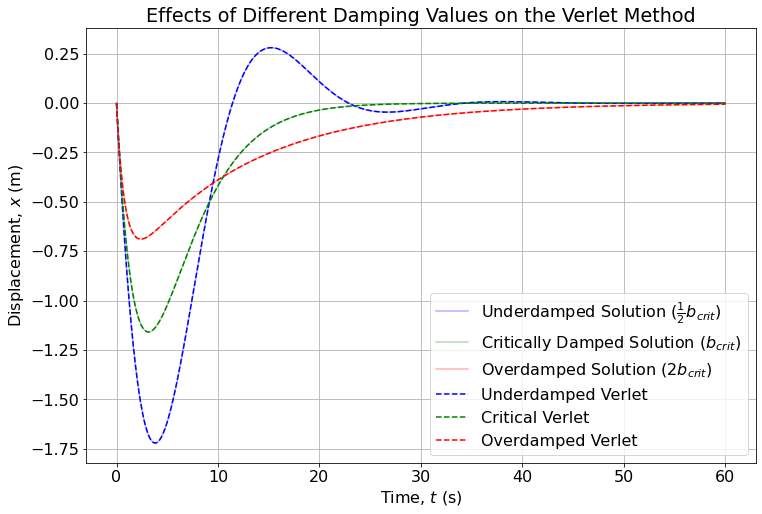

In [11]:
times_reduced = times[0:np.where(times == 60)[0][0]]
analytic_half_crit = analytic_half_crit[0:np.where(times == 60)[0][0]]
analytic_crit = analytic_crit[0:np.where(times == 60)[0][0]]
analytic_double_crit = analytic_double_crit[0:np.where(times == 60)[0][0]]

# Using the Euler Method to generate the second terms for the Verlet solutions
X_1_HCRIT = euler_improved(X_0, VEL_0, H, times_reduced, DAMPING_CRIT/2)[0][1]
X_1_CRIT = euler_improved(X_0, VEL_0, H, times_reduced, DAMPING_CRIT)[0][1]
X_1_DCRIT = euler_improved(X_0, VEL_0, H, times_reduced, 2*DAMPING_CRIT)[0][1]

# Generating the numerical Verlet solutions to the motion
verlet_half_crit = verlet(X_0, X_1_HCRIT, H, times_reduced, DAMPING_CRIT/2)
verlet_crit = verlet(X_0, X_1_CRIT, H, times_reduced, DAMPING_CRIT)
verlet_double_crit = verlet(X_0, X_1_DCRIT, H, times_reduced, 2*DAMPING_CRIT)

figure = plt.figure()
axes = figure.add_subplot(111)
axes.plot(times_reduced, analytic_half_crit, label = r"Underdamped Solution ($\frac{1}{2}b_{crit}$)", color="blue", alpha=0.3)
axes.plot(times_reduced, analytic_crit, label = r"Critically Damped Solution ($b_{crit}$)", color="green", alpha=0.3)
axes.plot(times_reduced, analytic_double_crit, label = r"Overdamped Solution ($2b_{crit}$)", color="red", alpha=0.3)
axes.plot(times_reduced, verlet_half_crit, label = r"Underdamped Verlet", color="blue", linestyle="dashed")
axes.plot(times_reduced, verlet_crit, label = r"Critical Verlet", color="green", linestyle="dashed")
axes.plot(times_reduced, verlet_double_crit, label = r"Overdamped Verlet", color="red", linestyle="dashed")
axes.set_xlabel("Time, $t$ (s)")
axes.set_ylabel("Displacement, $x$ (m)")
axes.grid()
axes.legend()
axes.set_title("Effects of Different Damping Values on the Verlet Method")
plt.show()

As shown above, there appear to be no major deviations between the standard Verlet method and the analytical solution at each of the different damping values outlined, further showing that the Verlet method is incredibly accurate for many cases in this system.

## Driving the System Using Forces

### Part 1 - Instantaneous Pulses
Now, we will investigate what happens when we add driving forces to the initially undriven system. Firsly, let's investigate what happens when we drive the system with a sudden, instantaneous pulse of $\pm$200N at various points in time. Given that this force acts as a delta function, it will likely be beyond the scope of this project to solve analytically due to requiring a Green's function solution and a Fourier transform (unlike a sinusoidal case, which is far more straightforward to solve). Hence, Verlet's method will be comapared to Euler-Cromer as another good approximation for the analytical case, given that another method is required to generate the second set of values used in the Verlet method.

Firstly, what happens if we apply a pulse at a stationary point (i.e. add at the point of maximum restoring force)?
In this case, I am assuming that a 'pulse' is effectively instantaneous - it acts as a delta function at some point in time.

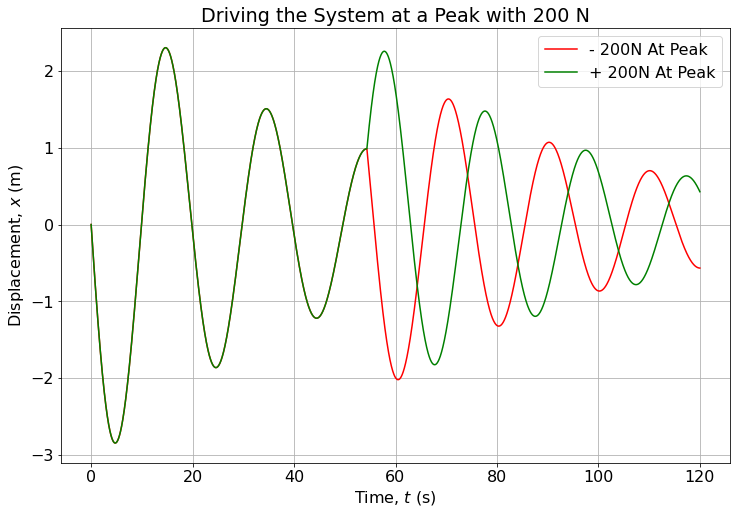

In [12]:
def verlet_drive(x_0, x_1, time_step, time, forces, B=DAMPING):
    d = 2 * M + B * time_step
    a = 2 * (2 * M - K * time_step**2) / d
    b = (B * time_step - 2 * M) / d
    
    # Initial conditions now account for a driving force at some time
    x_arr = np.zeros(len(time))
    x_arr[0] = x_0
    x_arr[1] = x_1
    x_arr[2] = a * x_1 - b * x_0 + (2 * time_step**2 * forces[2])/(2 * M + B * time_step)
    
    for i in range(len(time)-1):
        if i <= 1:
            continue
        else:
            # Added force/mass to the defintion of a_i and solved the Verlet method for x_i+1
            # This method will now appropriately account for any forces present at any time
            x_arr[i+1] = a * x_arr[i] + b * x_arr[i-1] + (2 * time_step**2 * forces[i])/(2 * M + B * time_step)
    return x_arr.real

def euler_cromer_drive(x_0, vel_0, time_step, time, forces, B=DAMPING):
    # Implementation of the Euler-Cromer Method to  use as a comparison when applying a driving force
    x_arr = np.zeros(len(time))
    vel_arr = np.zeros(len(time))
    x_arr[0] = x_0
    vel_arr[0] = vel_0
    
    # Considers the dynamics of the spring as a series of linear gradients with a fixed time step, H.
    for i in range(len(time)-1):
        # Now accounts for some driving force acting on the system and thus contributing to the acceleration
        acc = -(K/M) * x_arr[i] -(B/M) * vel_arr[i] + forces[i]/M
        vel_next = vel_arr[i] + time_step * acc
        if i < len(time):
            vel_arr[i+1] = vel_next
        x_arr[i+1] = x_arr[i] + vel_next * time_step

    return x_arr.real, vel_arr

forces_peak = np.zeros((len(times)))
x_cromer, vel_cromer = euler_cromer_drive(X_0, VEL_0, H, times, forces_peak)
X_1 = x_cromer[1]
statpoints = np.where(abs(vel_cromer) <= 0.001)[0]

peak = statpoints[5]
minimum_left = statpoints[4]
minimum_right = statpoints[6]

forces_peak[peak] = 200 # in N
x_peak = verlet_drive(X_0, X_1, H, times, forces_peak)
x_peak_neg = verlet_drive(X_0, X_1, H, times, -forces_peak)
figure = plt.figure()
axes = figure.add_subplot(111)
axes.plot(times, x_peak_neg, label = r"- 200N At Peak", color="red", alpha=1)
axes.plot(times, x_peak, label = r"+ 200N At Peak", color="green")
axes.set_xlabel("Time, $t$ (s)")
axes.set_ylabel("Displacement, $x$ (m)")
axes.grid()
axes.legend()
axes.set_title("Driving the System at a Peak with 200 N")
plt.show()

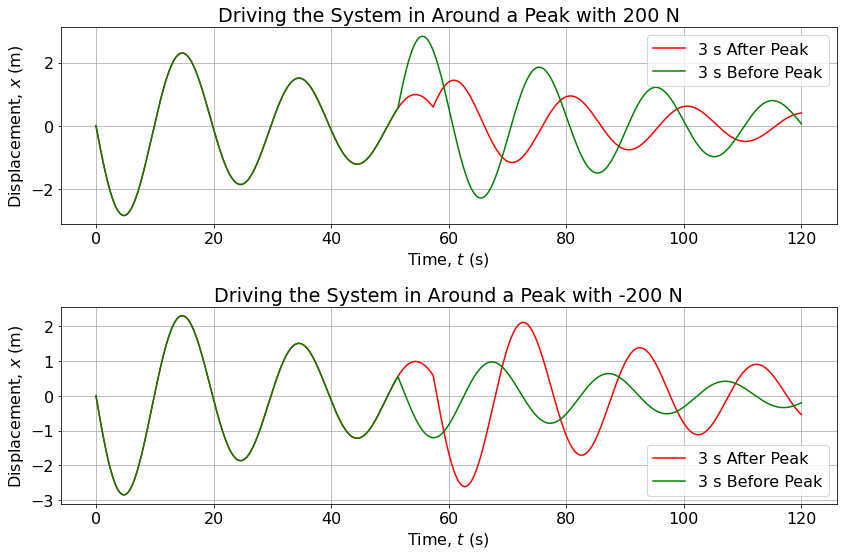

In [13]:
forces_peak_delay = np.zeros(len(times))
forces_peak_advance = np.zeros(len(times))
forces_peak_delay[peak + 150] = 200 # in N
forces_peak_advance[peak - 150] = 200 # in N

x_pdelay = verlet_drive(X_0, X_1, H, times, forces_peak_delay)
x_padvance = verlet_drive(X_0, X_1, H, times, forces_peak_advance)
figure = plt.figure()
axes = figure.add_subplot(211)
axes.plot(times, x_pdelay, label = r"3 s After Peak", color="red", alpha=1)
axes.plot(times, x_padvance, label = r"3 s Before Peak", color="green")
axes.set_xlabel("Time, $t$ (s)")
axes.set_ylabel("Displacement, $x$ (m)")
axes.grid()
axes.legend()
axes.set_title("Driving the System in Around a Peak with 200 N")

x_pdelay_neg = verlet_drive(X_0, X_1, H, times, -forces_peak_delay)
x_padvance_neg = verlet_drive(X_0, X_1, H, times, -forces_peak_advance)

axes_2 = figure.add_subplot(212)
axes_2.plot(times, x_pdelay_neg, label = r"3 s After Peak", color="red", alpha=1)
axes_2.plot(times, x_padvance_neg, label = r"3 s Before Peak", color="green")
axes_2.set_xlabel("Time, $t$ (s)")
axes_2.set_ylabel("Displacement, $x$ (m)")
axes_2.grid()
axes_2.legend()
axes_2.set_title("Driving the System in Around a Peak with -200 N")
plt.tight_layout()
plt.show()

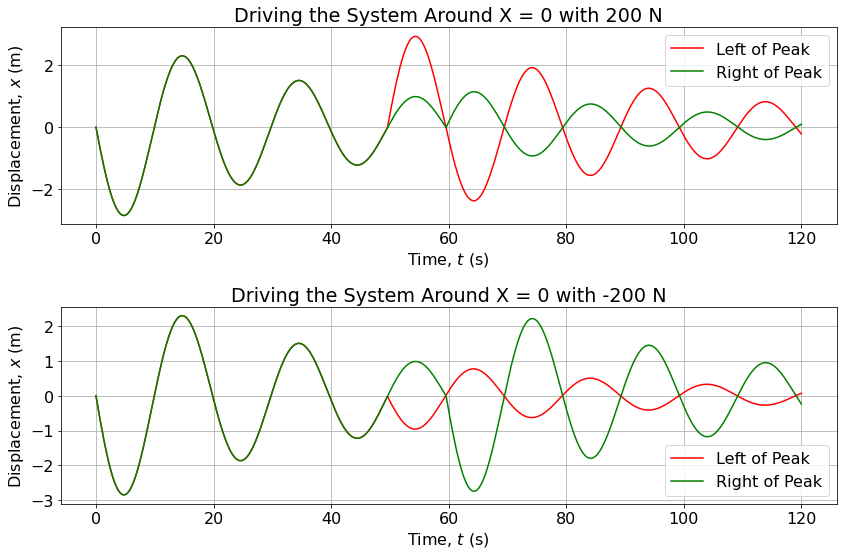

In [14]:
forces_zero_right, forces_zero_left = np.zeros((len(times))), np.zeros((len(times)))
zeroes = np.where(abs(x_cromer) <= 0.01)[0]
zero_right = zeroes[13]
zero_left = zeroes[7]

forces_zero_right[zero_right] = 200
forces_zero_left[zero_left] = 200

x_zright = verlet_drive(X_0, X_1, H, times, forces_zero_right)
x_zright_neg = verlet_drive(X_0, X_1, H, times, -forces_zero_right)
x_zleft = verlet_drive(X_0, X_1, H, times, forces_zero_left)
x_zleft_neg = verlet_drive(X_0, X_1, H, times, -forces_zero_left)

figure = plt.figure()
axes = figure.add_subplot(211)
axes.plot(times, x_zleft, label = r"Left of Peak", color="red", alpha=1)
axes.plot(times, x_zright, label = r"Right of Peak", color="green")
axes.set_xlabel("Time, $t$ (s)")
axes.set_ylabel("Displacement, $x$ (m)")
axes.grid()
axes.legend()
axes.set_title("Driving the System Around X = 0 with 200 N")
axes_2 = figure.add_subplot(212)
axes_2.plot(times, x_zleft_neg, label = r"Left of Peak", color="red", alpha=1)
axes_2.plot(times, x_zright_neg, label = r"Right of Peak", color="green")
axes_2.set_xlabel("Time, $t$ (s)")
axes_2.set_ylabel("Displacement, $x$ (m)")
axes_2.grid()
axes_2.legend()
axes_2.set_title("Driving the System Around X = 0 with -200 N")
plt.tight_layout()
plt.show()

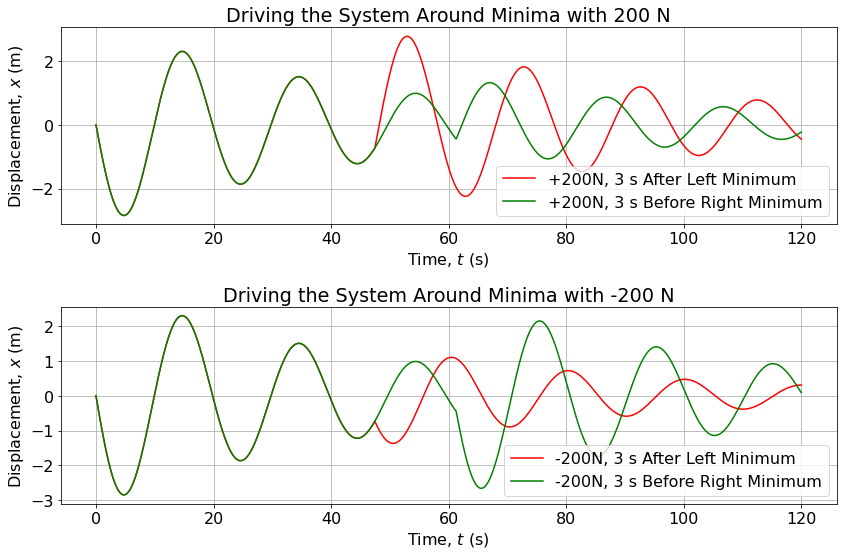

In [15]:
forces_min_left = np.zeros(len(times))
forces_min_left_delay = np.zeros(len(times))
forces_min_right = np.zeros(len(times))
forces_min_right_advance = np.zeros(len(times))

forces_min_left[minimum_left] = 200
forces_min_right[minimum_right] = 200
forces_min_left_delay[minimum_left + 150] = 200 # in N
forces_min_right_advance[minimum_right - 150] = 200 # in N

x_ml = verlet_drive(X_0, X_1, H, times, forces_min_left)
x_mr = verlet_drive(X_0, X_1, H, times, forces_min_right)
x_mldelay = verlet_drive(X_0, X_1, H, times, forces_min_left_delay)
x_mradvance = verlet_drive(X_0, X_1, H, times, forces_min_right_advance)

figure = plt.figure()
axes = figure.add_subplot(211)
axes_2 = figure.add_subplot(212)
axes.plot(times, x_mldelay, label = r"+200N, 3 s After Left Minimum", color="red", alpha=1)
axes.plot(times, x_mradvance, label = r"+200N, 3 s Before Right Minimum", color="green")
axes.set_xlabel("Time, $t$ (s)")
axes.set_ylabel("Displacement, $x$ (m)")
axes.grid()
axes.legend()
axes.set_title("Driving the System Around Minima with 200 N")

x_mldelay_neg = verlet_drive(X_0, X_1, H, times, -forces_min_left_delay)
x_mradvance_neg = verlet_drive(X_0, X_1, H, times, -forces_min_right_advance)

axes_2.plot(times, x_mldelay_neg, label = r"-200N, 3 s After Left Minimum", color="red", alpha=1)
axes_2.plot(times, x_mradvance_neg, label = r"-200N, 3 s Before Right Minimum", color="green")
axes_2.set_xlabel("Time, $t$ (s)")
axes_2.set_ylabel("Displacement, $x$ (m)")
axes_2.grid()
axes_2.legend()
axes_2.set_title("Driving the System Around Minima with -200 N")
plt.tight_layout()
plt.show()

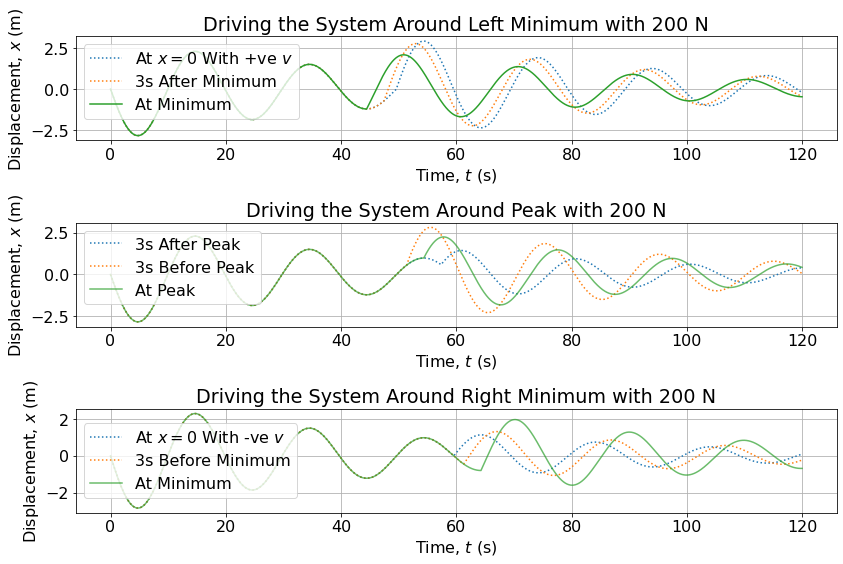

In [16]:
figure = plt.figure()
axes = figure.add_subplot(311)
axes_2 = figure.add_subplot(312)
axes_3 = figure.add_subplot(313)
axes.plot(times, x_zleft, label=r"At $x=0$ With +ve $v$", linestyle="dotted", alpha=1)
axes.plot(times, x_mldelay, label="3s After Minimum", linestyle="dotted", alpha=1)
axes.plot(times, x_ml, label="At Minimum", alpha=1)
axes.set_xlabel("Time, $t$ (s)")
axes.set_ylabel("Displacement, $x$ (m)")
axes.set_title("Driving the System Around Left Minimum with 200 N")
axes.grid()
axes.legend()

axes_2.plot(times, x_pdelay, label="3s After Peak", linestyle="dotted", alpha=1)
axes_2.plot(times, x_padvance, label="3s Before Peak", linestyle="dotted", alpha=1)
axes_2.plot(times, x_peak, label="At Peak", alpha=0.7)
axes_2.set_xlabel("Time, $t$ (s)")
axes_2.set_ylabel("Displacement, $x$ (m)")
axes_2.set_title("Driving the System Around Peak with 200 N")
axes_2.grid()
axes_2.legend()

axes_3.plot(times, x_zright, linestyle="dotted", label=r"At $x=0$ With -ve $v$", alpha=1)
axes_3.plot(times, x_mradvance, linestyle="dotted", label=r"3s Before Minimum", alpha=1)
axes_3.plot(times, x_mr, label=r"At Minimum", alpha=0.7)
axes_3.set_xlabel("Time, $t$ (s)")
axes_3.set_ylabel("Displacement, $x$ (m)")
axes_3.set_title("Driving the System Around Right Minimum with 200 N")
axes_3.grid()
axes_3.legend()
plt.tight_layout()
plt.show()

In the cases shown above, it is observed that if the driving force (and hence acceleration) is acting in the opposite direction to the displacement, then the oscillations will decrease in amplitude, providing a sort of external damping effect to the system. However, if the force is applied along the same direction as the instantaneous velocity, the amplitude of oscillation will incrase, esentially causing the system to oscillate to a more extreme degree.

This is compatible with the physical theory given Hooke's Law, $F = -kx$, so if the force added to the system acts opposite to the displacement, then the resultant force will decrease further, providing a faster return to x = 0 and often providing an overshoot (much like damping). 

When the driving force is acting in the direction of the next stationary point in velocity, (i.e. - x at points where x = 0 on the displacement graph) then the force causes a greater disturbance than when it acts against the direction of the next stationary point in velocity (x). If initially acting against the direction of restoring force at a turning point, then the magnitude of the disturbance caused by applying the force at different times will gradually increase to a maximum at the next stationary point. The opposite is true when applying the force in the same direction as a peak or minimum in displacement - when moving the timing of the pulse, the disturbance effect will be greatest at that initial stationary point in velocity and minimised at the next one .

### Part 2 - A Sinusoidal Driving Force

Now, a sinusoidal driving force, $F(t) = F_{0}\cos{(\omega t)}$ of magnitude $F_{0}$ and angular frequency $\omega$ will be simulated. An analytical solution to the contribution of this driving force is found easily:

$x(t) = A\exp{(i\omega t)}$, where $A = \frac{F_{0}}{m\sqrt{(\omega_{0}^{2} - \omega^{2})^{2} + (\gamma \omega)^{2}}}$, $\omega_{0}^{2} = \frac{k}{m}$, the natural frequency of the oscillator and $\gamma = \frac{b}{m}$. <br>
What happens to the system when forces of different frequencies are appplied? Using $F_{0}$ = 200 N as before, let's see what happens when $\omega$ is equal to:
- $\frac{1}{2} \omega_{0}$
- $\omega_{0}$
- $2 \omega_{0}$

This is not analogous to the damped case, as this does not affect the initial decay of the system, however interesting effects should be observed around the natural frequency.

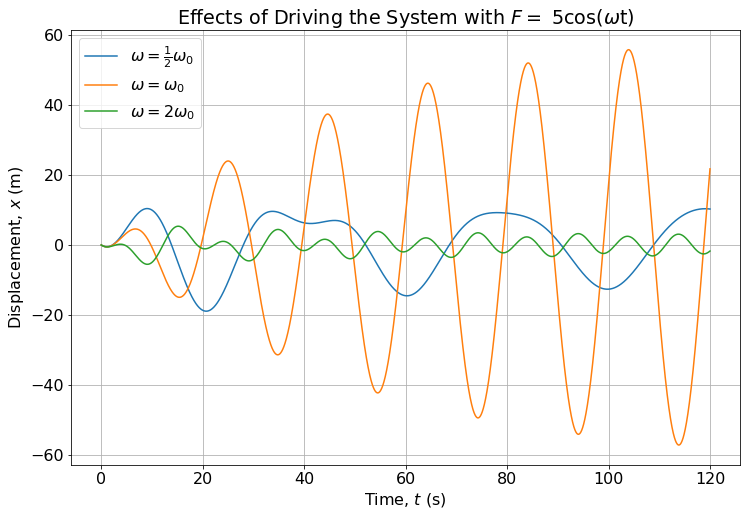

In [17]:
FORCE_0 = 5 # in N

# Generating values for the driving forces at different frequencies
forces_nat_half = FORCE_0 * np.cos(NAT_FREQ/2*times)
forces_nat = FORCE_0 * np.cos(NAT_FREQ*times)
forces_nat_double = FORCE_0 * np.cos(NAT_FREQ*2*times)

# Generating the numerical solutions to motion at the different driving frequencies
x_cromer, vel_cromer = euler_cromer_drive(X_0, VEL_0, H, times, forces_nat_half)
X_1 = x_cromer[1]
x_nat_half = verlet_drive(X_0, X_1, H, times, forces_nat_half)

x_cromer, vel_cromer = euler_cromer_drive(X_0, VEL_0, H, times, forces_nat)
X_1 = x_cromer[1]
x_nat = verlet_drive(X_0, X_1, H, times, forces_nat)

x_cromer, vel_cromer = euler_cromer_drive(X_0, VEL_0, H, times, forces_nat_double)
X_1 = x_cromer[1]
x_nat_double = verlet_drive(X_0, X_1, H, times, forces_nat_double)


"""
def analytical_cosine_drive(time, x0, v0, f0, freq, B=DAMPING):
    gamma = B/M
    amp = f0/(M*((NAT_FREQ**2-freq**2)**2 + (gamma*freq)**2))
    c = 1j*(cmath.sqrt(4*K*M - B**2)/(2*M))
    a = (x0 - v0 + amp*((gamma - 1)*freq**2 - NAT_FREQ**2))/(2*(1 + gamma))
    x = np.exp(-B*time/(2*M))*a*(np.exp(c*time) + np.exp(-c*time)) \
        + amp*((NAT_FREQ**2 - freq**2)*np.cos(freq*times) + gamma*freq*np.sin(freq*times))
    return x.real
"""

figure = plt.figure()
axes = figure.add_subplot(111)
axes.plot(times, x_nat_half, label=r"$\omega = \frac{1}{2}\omega_{0}$")
axes.plot(times, x_nat, label=r"$\omega = \omega_{0}$")
axes.plot(times, x_nat_double, label=r"$\omega = 2\omega_{0}$")
axes.set_xlabel("Time, $t$ (s)")
axes.set_ylabel("Displacement, $x$ (m)")
axes.set_title(r"Effects of Driving the System with $F =$ 5cos($\omega$t)")
axes.grid()
axes.legend()
plt.show()

As can be seen above, driving the system causes different modes of oscillation. If the frequency is not $\omega_{0}$, character of the undriven system (the transient response) remains for some time, preventing the system from having a simple sinusoidal solution. Over time, the initial vibrations are damped to such a level such that only the driven force remains and as such will tend towards a single sinusoidal solution as seen below:

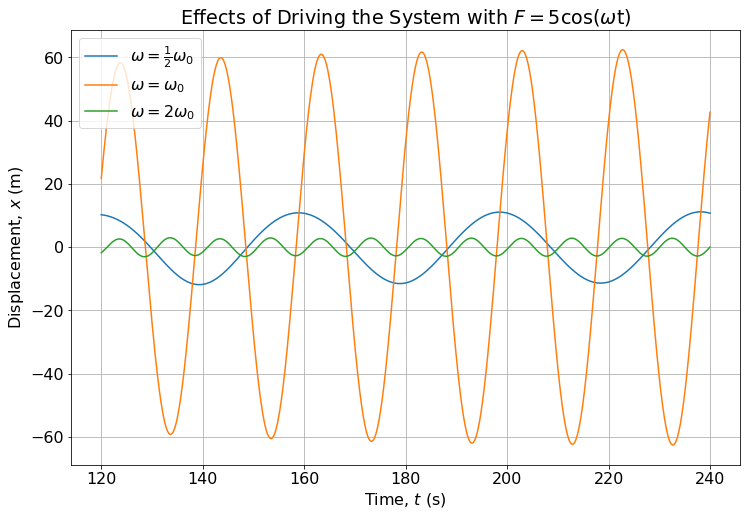

In [18]:
# Extending the region of simulation to show loss of transient response
new_times = np.arange(0, 2*TIME_MAX + H, H)
min_time_index = len(times) - 1
max_time_index = len(new_times) - 1

forces_nat_half = FORCE_0 * np.cos(NAT_FREQ/2*new_times)
forces_nat = FORCE_0 * np.cos(NAT_FREQ*new_times)
forces_nat_double = FORCE_0 * np.cos(NAT_FREQ*2*new_times)
x_nat_half = verlet_drive(X_0, X_1, H, new_times, forces_nat_half)
x_nat = verlet_drive(X_0, X_1, H, new_times, forces_nat)
x_nat_double = verlet_drive(X_0, X_1, H, new_times, forces_nat_double)

later_times = new_times[min_time_index:max_time_index]
x_nat_half_late = x_nat_half[min_time_index:max_time_index]
x_nat_late = x_nat[min_time_index:max_time_index]
x_nat_double_late = x_nat_double[min_time_index:max_time_index]

figure = plt.figure()
axes = figure.add_subplot(111)
axes.plot(later_times, x_nat_half_late, label=r"$\omega = \frac{1}{2}\omega_{0}$")
axes.plot(later_times, x_nat_late, label=r"$\omega = \omega_{0}$")
axes.plot(later_times, x_nat_double_late, label=r"$\omega = 2\omega_{0}$")
axes.set_xlabel("Time, $t$ (s)")
axes.set_ylabel("Displacement, $x$ (m)")
axes.set_title(r"Effects of Driving the System with $F =$5cos($\omega$t)")
axes.grid()
axes.legend()
plt.show()

After a reasonable time evolution, the system resorts to the solution of the driving force, unlike the undriven system, which only accounts for the steadily decaying transient response. It is clear that in this case, the solutions closest to $\omega_{0}$ will result in the largest amplitude response, given that the system is perfectly in phase with the driving force. This makes an interesting parallel with the damping cases - except for a driving force reaching the critical value <b> maximises </b> the displacement, rather than <b> minimising </b> the displacement.

In the case where the system is undamped and thus has a steady constant transient response, driving the system will instead cause the amplitude to increase to a steady value (unless forced at $\omega_{0}$):

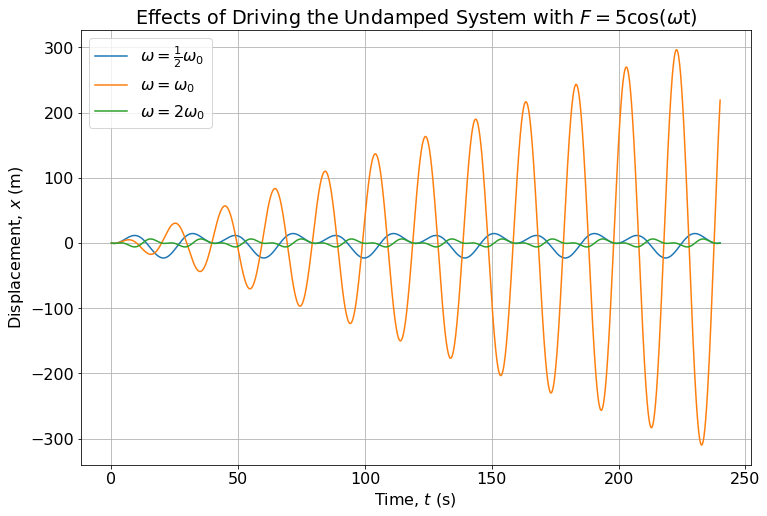

In [19]:
# Simulating undamped driven solutions
x_nat_half = verlet_drive(X_0, X_1, H, new_times, forces_nat_half, 0)
x_nat = verlet_drive(X_0, X_1, H, new_times, forces_nat, 0)
x_nat_double = verlet_drive(X_0, X_1, H, new_times, forces_nat_double, 0)

figure = plt.figure()
axes = figure.add_subplot(111)
axes.plot(new_times, x_nat_half, label=r"$\omega = \frac{1}{2}\omega_{0}$")
axes.plot(new_times, x_nat, label=r"$\omega = \omega_{0}$")
axes.plot(new_times, x_nat_double, label=r"$\omega = 2\omega_{0}$")
axes.set_xlabel("Time, $t$ (s)")
axes.set_ylabel("Displacement, $x$ (m)")
axes.set_title(r"Effects of Driving the Undamped System with $F =$5cos($\omega$t)")
axes.grid()
axes.legend()
plt.show()

In the undamped scenario, it is clear that the vibrations still retain a characteristic transient response throughout, leading to a more complicated solution. This is because, unless the system is driven at $\omega_{0}$, the driving force and vibrations will be at least partially out of phase, hence the force will partially drive against the system at points and drive along the system at other points, requiring a combination of sinusoidal terms to solve the system exactly. However, an interesting effect appears as the driving frequency tends to the natural frequency - in the damped case, the amplitude approaches a maximum and in the undamped case, the amplitude tends to infinity. This effect is known as resonance.

### Part 3 (Extension) - Resonance
Resonance naturally occurs in any vibrational system when vibrations are forced at the system's natural modes. As the frequency of the forced vibrations approach the natural frequency, the system comes more in phase and so the effect of the driven force is maximised, for example when notes are played using instruments, they occur at natural frequencies (or integer multiples of the natural frequencies), causing that note to be louder than other vibrations.

The analytical solution to the amplitude of oscillations driven by $\cos{(\omega t)}$ is $A(\omega) = \frac{F_{0}}{m\sqrt{(\omega_{0}^{2} - \omega^{2})^{2} + \frac{b\omega}{m}^{2}}}$

If the maximum amplitude of the forced system can be found for multiple frequencies, then we can compare the analytically found and numerically found amplitudes to investigate the resonance of the system.

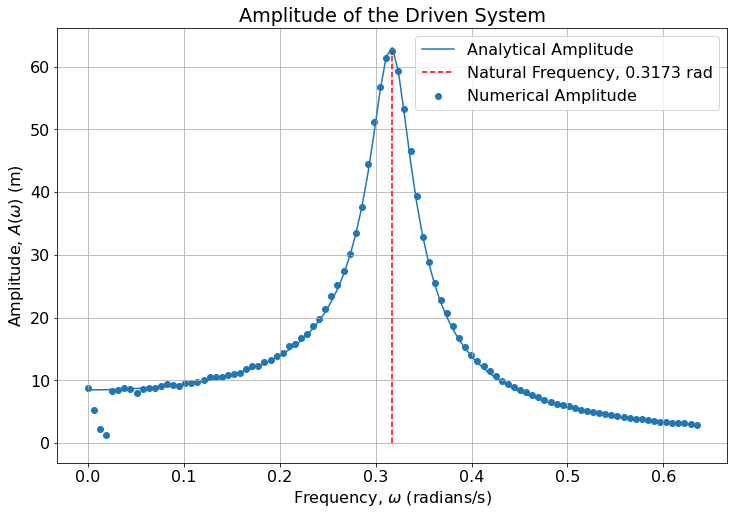

In [20]:
# Generating frequencies to simulate
frequencies = np.arange(0, 2 + 0.02, 0.02)*NAT_FREQ

def analytical_amplitude(force, frequency, B=DAMPING):
    # Returns the solution as defined above
    amplitude = force/(M*np.sqrt((NAT_FREQ**2 - frequency**2)**2 + (B*frequency/M)**2))
    return amplitude

# Directly sampling amplitudes by taking the maximum displacement once the transient response has died down
amplitudes = np.zeros((0))
time_i_low = np.where(new_times == 140)[0][0]
time_i_up = np.where(new_times == 240)[0][0]
for frequency in frequencies:
    forces = FORCE_0 * np.cos(frequency*new_times)
    displacements = verlet_drive(X_0, X_1, H, new_times, forces)
    amplitude = abs(max(displacements[time_i_low:time_i_up]))
    amplitudes = np.hstack((amplitudes,amplitude))
analytical_amp = analytical_amplitude(FORCE_0, frequencies)

# Directly illustrating the natural frequency
x_line = [NAT_FREQ, NAT_FREQ]
y_line = [0, max(amplitudes)]

figure = plt.figure()
axes = figure.add_subplot(111)
axes.scatter(frequencies, amplitudes, label=r"Numerical Amplitude")
axes.plot(frequencies, analytical_amp, label=r"Analytical Amplitude")
axes.plot(x_line, y_line, linestyle="dashed", color="red", label="Natural Frequency, {:.4g} rad".format(NAT_FREQ))
axes.set_xlabel("Frequency, $\omega$ (radians/s)")
axes.set_ylabel("Amplitude, $A(\omega)$ (m)")
axes.set_title(r"Amplitude of the Driven System")
axes.grid()
axes.legend()
plt.show()

As can be seen above, the Verlet method also provides an accurate simulation of the driven system's amplitude when compared to the analytical solution. The numerical solution is not accurate for small frequencies, only because the time range used to capture the amplitudes is too small compared to the period of the driving (otherwise the program would be needlessly slow), however it is past the point of resonable time evolution as demonstrated above.

The amplitude tends to a value above zero as $\omega \rightarrow 0$ , given that frequencies less than 0 radians are not valid and that the damping term is dominated by the undamped contribution. As $\omega \rightarrow \infty$, $A(\omega) \rightarrow 0$ because the system and driving force are completely out of phase. If $\omega \rightarrow \omega_{0}$, then the system experiences resonance due to the driving force being in phase with the natural frequency of resonance and so reaches its maximum amplitude. However, if the system was undamped, the amplitude would tend to an infinite value as it would gradually increase with time, this will carry on until the system breaks due to damage, for example vibrating glass at its resonant frequency (which substitutes $\omega_{0}$ in non-spring systems) will inevitably cause it to shatter.

This effect, especially when damped, can be used to great constructive effect in other scenarios, as mentioned before it allows certain frequencies of an instrument to dominate when vibrating (through strings, springs or otherwise), which are heard as defined, clear and loud notes.

## Extra: What Happens If the Critically Damped System is Driven?

What would theoretically happen if a critically damped system was driven at the natural frequency?
Given that the critically damped system does not oscillate, but the driving force does, we should expect a peak in the displacement shortly after the mass in the system starts moving, with a transient response that decays with time, leaving only the driving force.

However, what would happen if we used other frequencies? Would the lack of standard oscillation as provided in the undamped case cause all of the dirving forces to have similar amplitudes, or would they also display the characteristic resonance curve?

Let's find out:

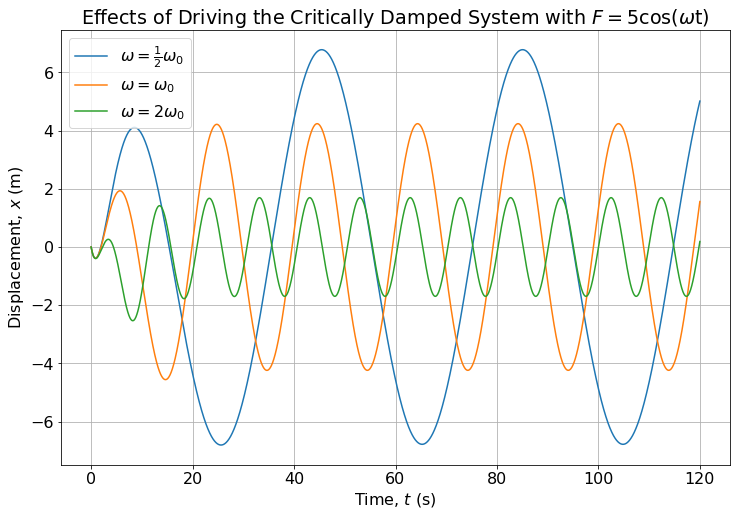

In [21]:
forces_nat_half = FORCE_0 * np.cos(NAT_FREQ/2*times)
forces_nat = FORCE_0 * np.cos(NAT_FREQ*times)
forces_nat_double = FORCE_0 * np.cos(NAT_FREQ*2*times)
x_nat_half = verlet_drive(X_0, X_1, H, times, forces_nat_half, DAMPING_CRIT)
x_nat = verlet_drive(X_0, X_1, H, times, forces_nat, DAMPING_CRIT)
x_nat_double = verlet_drive(X_0, X_1, H, times, forces_nat_double, DAMPING_CRIT)

figure = plt.figure()
axes = figure.add_subplot(111)
axes.plot(times, x_nat_half, label=r"$\omega = \frac{1}{2}\omega_{0}$")
axes.plot(times, x_nat, label=r"$\omega = \omega_{0}$")
axes.plot(times, x_nat_double, label=r"$\omega = 2\omega_{0}$")
axes.set_xlabel("Time, $t$ (s)")
axes.set_ylabel("Displacement, $x$ (m)")
axes.set_title(r"Effects of Driving the Critically Damped System with $F =$5cos($\omega$t)")
axes.grid()
axes.legend()
plt.show()

As somewhat expected, the transient response remains for a short period of time (and a shorter one than the undamped case) before tending to the solution of the driving force. So far, so normal.

<b> However </b>, it appears that the natural frequency no longer creates the largest amplitiude - instead, it appears that forces at lower frequencies do. The expectation that the amplitude decreases once the frequency increases past the natural frequency appears to hold however. This is especially strange, as the natural frequency does not depend on the damped case, however the Verlet method hs been shown to be accurate in both the critically damped case and the case where the system is driven in phase.

Let's plot the amplitude curve:

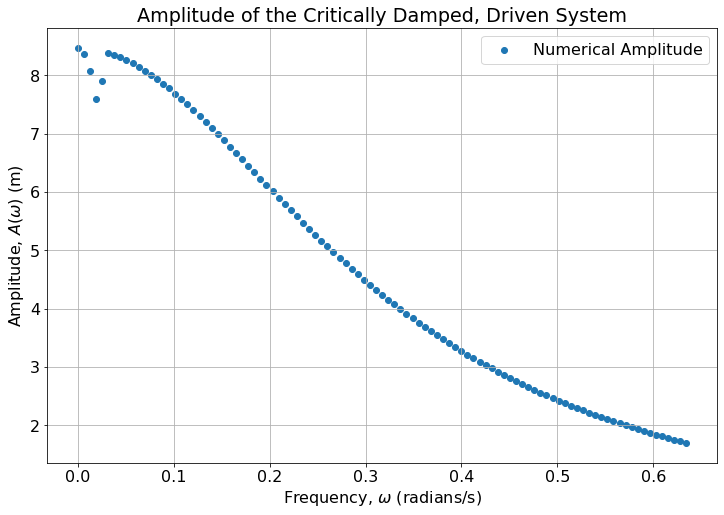

In [22]:
amplitudes = np.zeros((0))
time_i_low = np.where(new_times == 30)[0][0]
time_i_up = np.where(new_times == 240)[0][0]
for frequency in frequencies:
    forces = FORCE_0 * np.cos(frequency*new_times)
    displacements = verlet_drive(X_0, X_1, H, new_times, forces, DAMPING_CRIT)
    amplitude = abs(max(displacements[time_i_low:time_i_up]))
    amplitudes = np.hstack((amplitudes,amplitude))
    
figure = plt.figure()
axes = figure.add_subplot(111)
axes.scatter(frequencies, amplitudes, label=r"Numerical Amplitude")
axes.set_xlabel("Frequency, $\omega$ (radians/s)")
axes.set_ylabel("Amplitude, $A(\omega)$ (m)")
axes.set_title(r"Amplitude of the Critically Damped, Driven System")
axes.grid()
axes.legend()
plt.show()

Aside from previously mentioned inaccuracies at lower frequencies, the driven system has a larger amplitude than the undriven, critically-dapmed system. However, the maximum amplitude is now found in the case where $\omega \rightarrow 0$, i.e. the force is constant. This may be due to the critical damping having a strong tendency towards reducing the system to a minimum amplitude and so is more resistant to forces acting along or against the system. As higher frequency driving forces will on average be acting against the system to a greater degree, we should expect to see a greater degree of resistance against the driving force, which is observed. 

It is also of note that the maximum amplitude produced in the critically damped system is also significantly smaller than the maximum amplitude produced in the underdamped system. In addition, the turning point of this amplitude function appears to near to the natural frequency of the system.

Hence, in order to resnonate a critically damped system, a near-constant (or low frequency) driving force must be applied, however the range of frequencies that could create a notable resonance in the system seems to widen compared to underdamped case.

### Extra - Amplitude of the Overdamped System

Likewise, let's see what the amplitude of the overdamped system (at $2b_{crit}$, as before) is like:

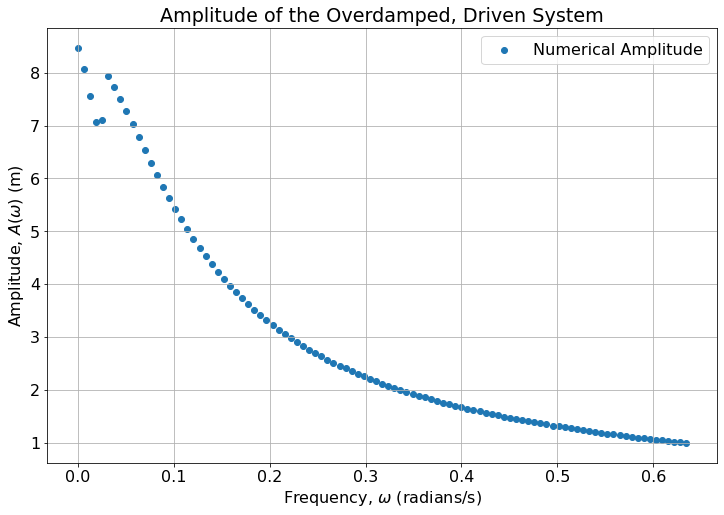

In [23]:
amplitudes = np.zeros((0))
for frequency in frequencies:
    forces = FORCE_0 * np.cos(frequency*new_times)
    displacements = verlet_drive(X_0, X_1, H, new_times, forces, 2*DAMPING_CRIT)
    amplitude = abs(max(displacements[time_i_low:time_i_up]))
    amplitudes = np.hstack((amplitudes,amplitude))
    
figure = plt.figure()
axes = figure.add_subplot(111)
axes.scatter(frequencies, amplitudes, label=r"Numerical Amplitude")
axes.set_xlabel("Frequency, $\omega$ (radians/s)")
axes.set_ylabel("Amplitude, $A(\omega)$ (m)")
axes.set_title(r"Amplitude of the Overdamped, Driven System")
axes.grid()
axes.legend()
plt.show()

Yet again, a similar result is observed as in the critically damped case (even maintaining the same maximum amplitude), however the amplitude appears to have a sharper falloff. This suggests that the overdamped system is even more resistant to being driven than the critically damped system.

What is the limit of this system, using $10b_{crit}$?

In [ ]:
amplitudes = np.zeros((0))
for frequency in frequencies:
    forces = FORCE_0 * np.cos(frequency*new_times)
    displacements = verlet_drive(X_0, X_1, H, new_times, forces, 10*DAMPING_CRIT)
    amplitude = abs(max(displacements[time_i_low:time_i_up]))
    amplitudes = np.hstack((amplitudes,amplitude))
    
figure = plt.figure()
axes = figure.add_subplot(111)
axes.scatter(frequencies, amplitudes, label=r"Numerical Amplitude")
axes.set_xlabel("Frequency, $\omega$ (radians/s)")
axes.set_ylabel("Amplitude, $A(\omega)$ (m)")
axes.set_title(r"Amplitude Limit of the Overdamped, Driven System")
axes.grid()
axes.legend()
plt.show()

It appears that, as $b \rightarrow \infty$, the range of values over which a notable resonance can be observed decreases and hence the system can only resonate when a constant force is applied.

In general, it seems that as the damping approaches $b_{crit}$ from the undamped case, the maximum amplitude will decrease to a stable minimum value and the peak of resonance will shift from $\omega_{0}$ to 0, indicating that approximately constant forces are required to resonate the system. The range of frequencies over which notable resonance is observed appears to increase to up until the system is damped at $b_{crit}$. As the system becomes progressively more overdamped, the maximum amplitude remains constant and the peak of resonance remains at $\omega = 0$, but the width of resonance decreases until it is effectively 0.  